# Compare models for visual proprioception

Compares regression models for visual proprioception, by running them on specific test data, and creating comparison graphs that put all of them onto the graphs. 

Each configuration is specified by a run of type visual_proprioception.

In [1]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import math
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

# from behavior_cloning.demo_to_trainingdata import BCDemonstration
from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn, sp_vit
# from robot.al5d_position_controller import RobotPosition

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training, get_visual_proprioception_sp, load_multiview_demonstrations_as_proprioception_training ,load_concat_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression
from visproprio_helper import get_visual_proprioception_sp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Loading pointer config file: /home/ssheikholeslami/.config/BerryPicker/mainsettings.yaml
Loading machine-specific config file: /home/ssheikholeslami/SaharaBerryPickerData/settings-sahara.yaml


In [ ]:

# Define helper functions for device management
def force_to_device(model, target_device):
    """Make sure model and all its parameters are on the target device"""
    if model is None:
        return None
    model = model.to(target_device)
    # Also check parameters to be extra sure
    for param in model.parameters():
        if param.device != target_device:
            param.data = param.data.to(target_device)
    return model

def ensure_tensor_on_device(x, target_device):
    """Make sure x is a tensor and is on the correct device"""
    if not isinstance(x, torch.Tensor):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        else:
            x = torch.tensor(x, dtype=torch.float32)
    return x.to(target_device)

# Wrapper for model forward pass with device safety
def safe_model_forward(model, x, target_device):
    """Run model forward pass with device safety checks"""
    model = force_to_device(model, target_device)
    x = ensure_tensor_on_device(x, target_device)

    # Add batch dimension if needed
    if len(x.shape) == 1:
        x = x.unsqueeze(0)

    # Safety check to verify everything is on the right device
    model_device = next(model.parameters()).device
    if x.device != model_device:
        print(f"Device mismatch! Input is on {x.device}, model is on {model_device}")
        x = x.to(model_device)

    return model(x)

In [ ]:
experiment = "visual_proprioception"

# the lead run is the one that will provide the test data.
# also the directory of this run is where the graphs will be saved.

# all of them
# leadrun = "comp_all"
# leadrun = "comp_vae"
# leadrun = "comp_resnet"
# leadrun = "comp_vgg"
# leadrun = "comp_all_with_vit"
# leadrun = "comp_vit"
# leadrun = "comp_aruco"
# leadrun = "comp_vit_multiview_base"
# leadrun = "comp_vit_multiview_large"
# leadrun = "comp_vit_multiview_all"
# leadrun = "comp_resnet_multiview"
# leadrun = "comp_vgg_multiview"
# leadrun = "comp_vae_concat_multiview"
# leadrun = "comp_multiview_all"
# leadrun = "comp_all_with_vit_concat"
leadrun = "comp_vit_large_all"

# Load lead experiment configuration
leadexp = Config().get_experiment(experiment, leadrun)
runs = leadexp["tocompare"]

# Load all models and sensor processors
exps = []
sps = []
models = []
for run in runs:
    exp = Config().get_experiment(experiment, run)
    exps.append(exp)

    # Load and ensure sensor processor is on the right device
    sp = get_visual_proprioception_sp(exp, device)
    # If sp has an encoder, make sure it's on the right device
    if hasattr(sp, 'enc') and hasattr(sp.enc, 'to'):
        sp.enc = force_to_device(sp.enc, device)
    # If sp has a model attribute, make sure it's on the right device
    if hasattr(sp, 'model') and hasattr(sp.model, 'to'):
        sp.model = force_to_device(sp.model, device)
    sps.append(sp)

    # Load and ensure model is on the right device
    model = VisProprio_SimpleMLPRegression(exp)
    modelfile = pathlib.Path(exp["data_dir"], exp["proprioception_mlp_model_file"])
    model.load_state_dict(torch.load(modelfile, map_location=device))
    model = force_to_device(model, device)
    model.eval()  # Set model to evaluation mode
    print(f"Model {exp.get('name', 'unknown')} is on device: {next(model.parameters()).device}")
    models.append(model)

No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/visual_proprioception/comp_vae_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/comp_vae successfully loaded
No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/visual_proprioception/vp_convvae_128_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_convvae_128 successfully loaded
No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/sensorprocessing_conv_vae/proprio_128_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: sensorprocessing_conv_vae/proprio_128 successfully loaded
Model conv-vae-128 is on device: cuda:0
No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/visual_proprioception/vp_convvae_256_sysdep.yaml,
 that is ok, proceeding.
Configura

/tmp/ipykernel_2118752/455289363.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelfile, map_location=device))


No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/sensorprocessing_conv_vae_concat_multiview/proprio_128_concat_multiview_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: sensorprocessing_conv_vae_concat_multiview/proprio_128_concat_multiview successfully loaded
Model conv-vae-128-concat-multiview-width is on device: cuda:0
No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/visual_proprioception/vp_convvae_256_concat_multiview_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: visual_proprioception/vp_convvae_256_concat_multiview successfully loaded
No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/sensorprocessing_conv_vae_concat_multiview/proprio_256_concat_multiview_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: sensorprocessing_conv_vae_concat_multiview/proprio_256_concat_multivi

#old version was working for one by one but not for mixe dif single and doubel views

In [ ]:
# experiment = "visual_proprioception"

# # the lead run is the one that will provide the test data.
# # also the directory of this run is where the graphs will be saved.

# # all of them
# # leadrun = "comp_all"
# # leadrun = "comp_vae"
# # leadrun = "comp_resnet"
# # leadrun = "comp_vgg"
# # leadrun = "comp_all_with_vit"
# # leadrun = "comp_vit"
# # leadrun = "comp_aruco"
# # leadrun = "comp_vit_multiview_base"
# # leadrun = "comp_vit_multiview_large"
# # leadrun = "comp_vit_multiview_all"
# # leadrun = "comp_resnet_multiview"
# # leadrun = "comp_vgg_multiview"
# # leadrun = "comp_vae_concat_multiview"
# # leadrun = "comp_multiview_all"
# leadrun = "comp_all_with_vit_concat"
# leadrun = "comp_vit_large_all"


# # now load them

# leadexp = Config().get_experiment(experiment, leadrun)

# runs = leadexp["tocompare"]

# # runs = ["vp_convvae_128", "vp_convvae_256", "vp_ptun_vgg19_128", "vp_ptun_vgg19_256", "vp_ptun_resnet50_128", "vp_ptun_resnet50_256", "vp_aruco_128"]
# # runs = "vp_ptun_resnet50_128_multiview"

# print(runs)

# exps = []
# sps = [ ]
# models = [ ]
# for run in runs:
#     exp = Config().get_experiment(experiment, run)
#     exps.append(exp)
#     sp = get_visual_proprioception_sp(exp, device)
#     sps.append(sp)
#     model = VisProprio_SimpleMLPRegression(exp)
#     modelfile = pathlib.Path(exp["data_dir"],
#                             exp["proprioception_mlp_model_file"])
#     # model.load_state_dict(torch.load(modelfile))

#     # Do this instead:
#     checkpoint = torch.load(modelfile)
#     if "model_state_dict" in checkpoint:
#         # This is a checkpoint file with metadata
#         model.load_state_dict(checkpoint["model_state_dict"])
#     else:
#         # This is a simple state dict file
#         model.load_state_dict(checkpoint)
#     models.append(model)


In [ ]:

# Process and evaluate each model on its own test data
print("\n=== Evaluating Each Model on its Own Test Data ===")
ypreds = []
targets_list = []
model_data_lengths = []

for i, (exp, sp, model) in enumerate(zip(exps, sps, models)):
    print(f"\nProcessing model {i+1}/{len(models)}: {exp.get('name', 'unknown')}")

    # Get model's own test data paths
    task = exp["proprioception_testing_task"]
    proprioception_input_file = pathlib.Path(exp["data_dir"], exp["proprioception_test_input_file"])
    proprioception_target_file = pathlib.Path(exp["data_dir"], exp["proprioception_test_target_file"])

    # Determine model type
    is_multiview = (
        exp.get("sensor_processing", "") == "Vit_multiview" or
        exp.get("sensor_processing", "").endswith("_multiview") or
        exp.get("num_views", 1) > 1
    )
    is_concat = exp.get("sensor_processing", "") == "Vit_concat_images"

    # Process with appropriate approach
    try:
        # Load appropriate data for this specific model
        if is_multiview:
            if is_concat:
                print(f"Loading concat multi-view test data")
                tr = load_concat_demonstrations_as_proprioception_training(
                    task, proprioception_input_file, proprioception_target_file,
                    num_views=exp.get("num_views", 2)
                )

                # Process using concat approach
                ypred = []
                with torch.no_grad():
                    for j in range(tr["targets"].shape[0]):
                        # Move both model and views to device
                        model = force_to_device(model, device)
                        views = [view[j].unsqueeze(0).to(device) for view in tr["raw_views"]]

                        # Process with extra safety
                        try:
                            latent = sp.enc.encode(views)
                            latent = ensure_tensor_on_device(latent, device)
                            predictions = safe_model_forward(model, latent, device)
                            ypred.append(predictions.cpu().numpy()[0])
                        except RuntimeError as e:
                            print(f"Error in concat processing: {e}")
                            # Try CPU as fallback
                            print("Falling back to CPU processing")
                            model = model.cpu()
                            latent = sp.enc.encode([v.cpu() for v in views])
                            latent = ensure_tensor_on_device(latent, torch.device('cpu'))
                            predictions = model(latent)
                            ypred.append(predictions.numpy()[0])
            else:
                print(f"Loading standard multi-view test data")
                tr = load_multiview_demonstrations_as_proprioception_training(
                    task, proprioception_input_file, proprioception_target_file,
                    num_views=exp.get("num_views", 2)
                )

                # Process using standard multi-view approach
                ypred = []
                with torch.no_grad():
                    for j in range(tr["targets"].shape[0]):
                        # Move both model and views to device
                        model = force_to_device(model, device)
                        views = [view[j].unsqueeze(0).to(device) for view in tr["view_inputs"]]

                        # Process with extra safety
                        try:
                            latent = sp.process(views)
                            latent_tensor = ensure_tensor_on_device(latent, device)

                            # Ensure batch dimension
                            if len(latent_tensor.shape) == 1:
                                latent_tensor = latent_tensor.unsqueeze(0)

                            predictions = safe_model_forward(model, latent_tensor, device)
                            ypred.append(predictions.cpu().numpy()[0])
                        except RuntimeError as e:
                            print(f"Error in multi-view processing: {e}")
                            # Try CPU as fallback
                            print("Falling back to CPU processing")
                            model = model.cpu()
                            latent = sp.process([v.cpu() for v in views])
                            latent_tensor = ensure_tensor_on_device(latent, torch.device('cpu'))
                            if len(latent_tensor.shape) == 1:
                                latent_tensor = latent_tensor.unsqueeze(0)
                            predictions = model(latent_tensor)
                            ypred.append(predictions.numpy()[0])
        else:
            print(f"Loading single-view test data")
            tr = load_demonstrations_as_proprioception_training(
                sp, task, proprioception_input_file, proprioception_target_file
            )
            inputs = tr["inputs"]

            # Process using single-view approach
            ypred = []
            with torch.no_grad():
                for j in range(tr["targets"].shape[0]):
                    # Move both model and input to device
                    model = force_to_device(model, device)
                    x = inputs[j].to(device)

                    # Process with extra safety
                    try:
                        # Ensure batch dimension
                        x_batch = x.unsqueeze(0)
                        predictions = safe_model_forward(model, x_batch, device)
                        ypred.append(predictions.cpu().numpy()[0])
                    except RuntimeError as e:
                        print(f"Error in single-view processing: {e}")
                        # Try CPU as fallback
                        print("Falling back to CPU processing")
                        model = model.cpu()
                        x = x.cpu().unsqueeze(0)
                        predictions = model(x)
                        ypred.append(predictions.numpy()[0])

        # Store the results
        targets = tr["targets"].numpy()
        ypred = np.array(ypred)

        # Calculate and print MSE for this model
        mse = np.mean(np.sum((ypred - targets) ** 2, axis=1))
        print(f"Model {exp.get('name', 'unknown')} MSE: {mse:.6f}")
        print(f"Test data points: {targets.shape[0]}")

        # Verify that targets have the expected 6D shape
        assert targets.shape[1] == 6, f"Expected 6D target data, got {targets.shape[1]}D"

        # Store for plotting
        ypreds.append(ypred)
        targets_list.append(targets)
        model_data_lengths.append(targets.shape[0])

    except Exception as e:
        print(f"Error processing model {exp.get('name', 'unknown')}: {str(e)}")
        print("Skipping this model and continuing with others")
        continue

# Make sure we have at least one model processed successfully
if len(ypreds) == 0:
    print("ERROR: No models were processed successfully. Exiting.")
    sys.exit(1)

# Verify that all targets are the same
all_targets_match = True
for i in range(1, len(targets_list)):
    # First check if lengths match before comparing content
    if targets_list[0].shape[0] != targets_list[i].shape[0]:
        print(f"Warning: Target count for model {exps[i]['name']} ({targets_list[i].shape[0]}) " +
              f"doesn't match model {exps[0]['name']} ({targets_list[0].shape[0]})")
        all_targets_match = False
    else:
        # Compare targets content
        if not np.allclose(targets_list[0], targets_list[i], atol=1e-5):
            print(f"Warning: Targets for model {exps[i]['name']} don't match model {exps[0]['name']}")
            # Show first mismatch
            mismatch = ~np.isclose(targets_list[0], targets_list[i], atol=1e-5)
            first_mismatch = np.argwhere(mismatch)[0]
            print(f"First mismatch at index {first_mismatch[0]}, dimension {first_mismatch[1]}")
            print(f"Value in {exps[0]['name']}: {targets_list[0][first_mismatch[0], first_mismatch[1]]}")
            print(f"Value in {exps[i]['name']}: {targets_list[i][first_mismatch[0], first_mismatch[1]]}")
            all_targets_match = False

if all_targets_match:
    print("\nVerified: All models have identical target data.")
else:
    print("\nWarning: Not all models have identical target data. Using first model's targets as reference.")

# Use the targets from the first model as the reference for plotting
reference_targets = targets_list[0]

# Find the shortest data length for consistent plotting
min_data_length = min(model_data_lengths)
print(f"\nUsing the first {min_data_length} data points for all models in plots")

# Trim data to the common length
for i in range(len(ypreds)):
    if ypreds[i].shape[0] > min_data_length:
        ypreds[i] = ypreds[i][:min_data_length]

# Trim reference targets to the common length
if reference_targets.shape[0] > min_data_length:
    reference_targets = reference_targets[:min_data_length]

# Create time series array for plotting
t = np.array(range(min_data_length))



=== Evaluating Each Model on its Own Test Data ===

Processing model 1/4: conv-vae-128
Loading single-view test data
Model conv-vae-128 MSE: 0.627980
Test data points: 957

Processing model 2/4: conv-vae-256
Loading single-view test data
Model conv-vae-256 MSE: 0.506435
Test data points: 957

Processing model 3/4: conv-vae-128-concat-multiview-width
Loading standard multi-view test data
Loading cached data from /home/ssheikholeslami/SaharaBerryPickerData/experiment_data/visual_proprioception/vp_convvae_128_concat_multiview/test_inputs.pt
Created 641 training examples and 316 validation examples
Model conv-vae-128-concat-multiview-width MSE: 0.802789
Test data points: 957

Processing model 4/4: conv-vae-256-concat-multiview-width
Loading standard multi-view test data
Loading cached data from /home/ssheikholeslami/SaharaBerryPickerData/experiment_data/visual_proprioception/vp_convvae_256_concat_multiview/test_inputs.pt
Created 641 training examples and 316 validation examples
Model conv

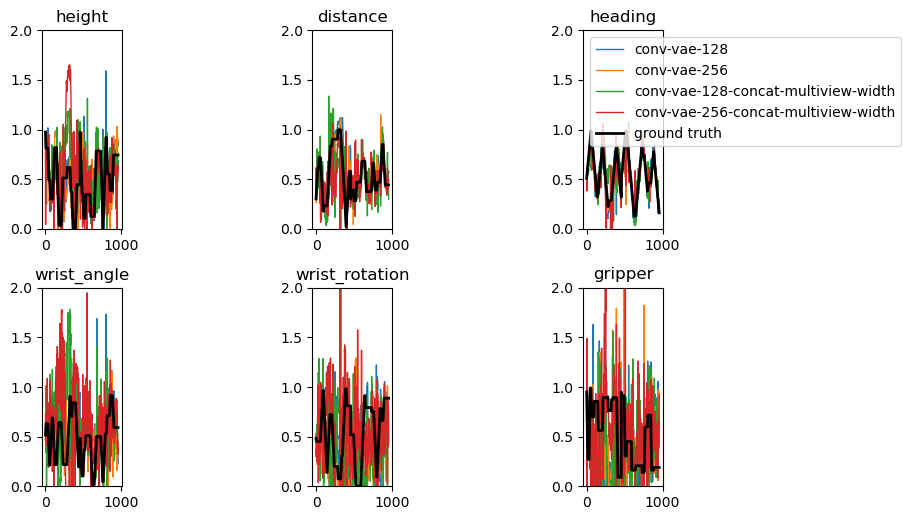

In [ ]:
# Create time series array for plotting
t = np.array(range(min_data_length))

# Create standard comparison plots
# Time compare plot, single column (all models)
fig, axs = plt.subplots(2, 3, figsize=(7, 5.3))
titles = ["height", "distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3]
    ax.set_ylim(0, 2.0)
    for j, (ypred, exp) in enumerate(zip(ypreds, exps)):
        ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
    # Use reference targets for ground truth
    ax.plot(t, reference_targets[:,i], label="ground truth", linewidth=2, color="black")
    if i==2:
        ax.legend()
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

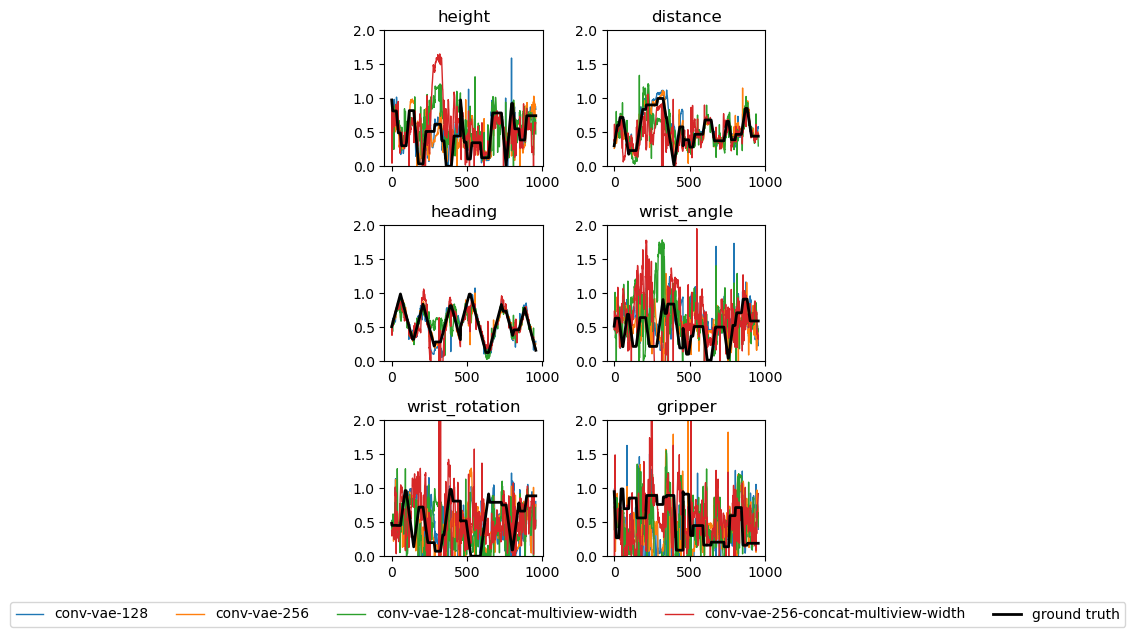

In [ ]:

# Time compare plot, vertical with legend on bottom
fig, axs = plt.subplots(3, 2, figsize=(4.6, 6))
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//2, i%2]
    ax.set_ylim(0, 2.0)
    for j, (ypred, exp) in enumerate(zip(ypreds, exps)):
        ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
    # Use reference targets for ground truth
    ax.plot(t, reference_targets[:,i], label="ground truth", linewidth=2, color="black")
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=len(exps)+1,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

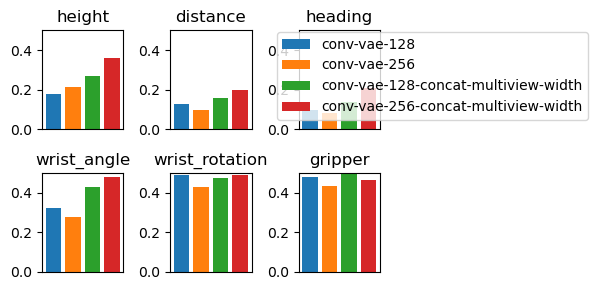

In [ ]:

# MSE Comparison plot in double column format
fig, axs = plt.subplots(2, 3, figsize=(4, 3))
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3]
    ax.set_ylim(0, 0.5)
    bars = []
    names = []
    for j, (ypred, exp) in enumerate(zip(ypreds, exps)):
        # Use the same reference targets for all MSE calculations
        error = math.sqrt(np.mean((reference_targets[:,i] - ypred[:,i]) ** 2))
        br = ax.bar(exp["name"], error)
        bars.append(br)
        names.append(exp["name"])
    # Remove x-axis labels
    ax.set_xticks([])
    if i==0:
        fig.legend(bars, names, bbox_to_anchor=(1.50, 0.9), ncol=1)
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison.jpg")
plt.savefig(graphfilename, bbox_inches='tight')

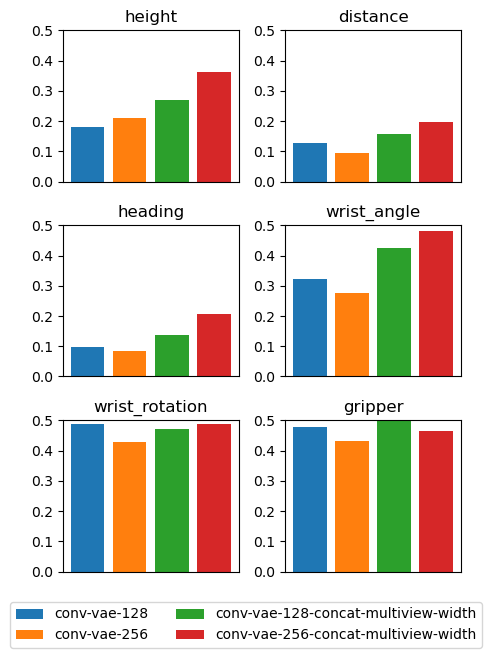

In [ ]:

# MSE Comparison plot in vertical format
fig, axs = plt.subplots(3, 2, figsize=(4.6, 6))
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//2, i%2]
    ax.set_ylim(0, 0.5)
    bars = []
    names = []
    for j, (ypred, exp) in enumerate(zip(ypreds, exps)):
        # Use the same reference targets for all MSE calculations
        error = math.sqrt(np.mean((reference_targets[:,i] - ypred[:,i]) ** 2))
        br = ax.bar(exp["name"], error, label=exp["name"])
        bars.append(br)
        names.append(exp["name"])
    # Remove x-axis labels
    ax.set_xticks([])
    if i==4:
        handles, labels = ax.get_legend_handles_labels()
        ncolumn = 2
        fig.legend(handles, labels, ncol=ncolumn,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.pdf")
plt.savefig(graphfilename, bbox_inches='tight')
graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.jpg")
plt.savefig(graphfilename, bbox_inches='tight')


In [ ]:

print("\nAll plots have been saved")


All plots have been saved


In [ ]:
# # Load test data for the lead experiment
# task = leadexp["proprioception_testing_task"]
# proprioception_input_file = pathlib.Path(
#     leadexp["data_dir"], leadexp["proprioception_test_input_file"])
# proprioception_target_file = pathlib.Path(
#     leadexp["data_dir"], leadexp["proprioception_test_target_file"])

# print(leadexp)
# print(exp)
# # Helper function to determine model type
# def get_model_type(leadexp):
#     """Helper function to determine the type of model based on experiment config"""
#     sensor_processing = exp.get("sensor_processing", "")

#     # Check if this is a CNN-based multi-view model
#     is_cnn_multiview = (
#         exp.get("sensor_processing", "") == "VGG19ProprioTunedSensorProcessing_multiview" or
#         exp.get("sensor_processing", "") == "ResNetProprioTunedSensorProcessing_multiview" or
#         "MultiView" in sensor_processing and any(x in sensor_processing for x in ["VGG", "ResNet", "CNN"])
#     )

#     # Check if this is a concat-image model
#     is_concat_model = (
#         sensor_processing == "Vit_concat_images" or
#         sensor_processing == "ConvVaeSensorProcessing_concat_multiview"
#         )


#     # Check if this is a ViT-based multi-view model
#     is_vit_multiview = (
#         sensor_processing == "Vit_multiview" or
#         sensor_processing.endswith("_multiview") and not is_cnn_multiview and not is_concat_model
#     )


#     # General multi-view check
#     is_multiview = is_cnn_multiview or is_vit_multiview or is_concat_model or exp.get("num_views", 1) > 1

#     return {
#         "is_multiview": is_multiview,
#         "is_cnn_multiview": is_cnn_multiview,
#         "is_vit_multiview": is_vit_multiview,
#         "is_concat_model": is_concat_model
#     }

# print(get_model_type(leadexp))
# # Determine lead experiment type
# lead_model_type = get_model_type(leadexp)
# is_lead_multiview = lead_model_type["is_multiview"]
# is_lead_concat = lead_model_type["is_concat_model"]
# is_lead_cnn_multiview = lead_model_type["is_cnn_multiview"]
# is_lead_vit_multiview =  lead_model_type["is_vit_multiview"]


# if is_lead_multiview:
#     if is_lead_concat:
#         print("Using concat image model data loading")
#         # Use the specialized concat loading function
#         tr = load_concat_demonstrations_as_proprioception_training(
#             task,
#             proprioception_input_file,
#             proprioception_target_file,
#             num_views=leadexp.get("num_views", 2)
#         )
#     elif is_lead_cnn_multiview or is_lead_vit_multiview:
#         print(f"Using standard multi-view data loading for lead experiment (type: {'CNN' if is_lead_cnn_multiview else 'ViT'})")
#         # Use standard multi-view loading function (works for both CNN and ViT)
#         tr = load_multiview_demonstrations_as_proprioception_training(
#             task,
#             proprioception_input_file,
#             proprioception_target_file,
#             num_views=leadexp.get("num_views", 2)
#         )

# else:
#     print("Using single-view data loading")
#     # Use original single-view loading function
#     tr = load_demonstrations_as_proprioception_training(
#         sp, task, proprioception_input_file, proprioception_target_file)

# # The targets should be the same regardless of approach
# targets = tr["targets"]
# print(f"There are {targets.shape[0]} data points")

In [ ]:
# # Evaluation Script
# no_from = 0
# no_to = targets.shape[0]

# ypreds = []

# for exp, sp, model in zip(exps, sps, models):
#     # Make sure model is on the right device
#     model = model.to(device)

#     task = exp["proprioception_testing_task"]
#     proprioception_input_file = pathlib.Path(
#         exp["data_dir"], exp["proprioception_test_input_file"])
#     proprioception_target_file = pathlib.Path(
#         exp["data_dir"], exp["proprioception_test_target_file"])

#     # Determine this model's type
#     model_type = get_model_type(exp)
#     is_multiview = model_type["is_multiview"]
#     is_concat_model = model_type["is_concat_model"]
#     is_cnn_multiview = model_type["is_cnn_multiview"]

#     if is_multiview:
#         if is_concat_model:
#             print(f"Evaluating concat model for experiment {exp.get('name', 'unknown')}")
#             # Use the concat-specific loading function
#             tr = load_concat_demonstrations_as_proprioception_training(
#                 task,
#                 proprioception_input_file,
#                 proprioception_target_file,
#                 num_views=exp.get("num_views", 2)
#             )

#             # Process each data point - raw_views is what we need here
#             ypred = []
#             y = []
#             t = []

#             with torch.no_grad():
#                 for i in range(no_from, no_to):
#                     # For concat model, we first need to get the latent features
#                     views = [view[i].unsqueeze(0).to(device) for view in tr["raw_views"]]

#                     # Extract features from the concat model encoder (don't use the whole model)
#                     # Pass the latent features to the MLP model (not the raw views)

#                     latent = sp.enc.encode(views)              # could be ndarray *or* tensor

#                     if not isinstance(latent, torch.Tensor):   # convert only when it’s NumPy
#                         latent = torch.from_numpy(latent)


#                     latent = latent.float().unsqueeze(0).to(device)    #  ← this line

#                     # latent = latent.float().to(device)         # dtype & device are unified
#                     predictions = model(latent)

#                     # Move predictions back to CPU for numpy conversion
#                     predictions_cpu = predictions.cpu()

#                     # Append the data
#                     t.append(i)
#                     y.append(targets[i].numpy())
#                     ypred.append(predictions_cpu[0].numpy())
#         elif is_cnn_multiview:
#             print(f"Evaluating CNN multi-view model for experiment {exp.get('name', 'unknown')}")
#             # Use the standard multi-view loading function (works for both ViT and CNN)
#             tr = load_multiview_demonstrations_as_proprioception_training(
#                 task,
#                 proprioception_input_file,
#                 proprioception_target_file,
#                 num_views=exp.get("num_views", 2)
#             )

#             # Process each data point with view_inputs
#             ypred = []
#             y = []
#             t = []

#             with torch.no_grad():
#                 for i in range(no_from, no_to):
#                     # Get the views from the dataset
#                     views = [view[i].unsqueeze(0).to(device) for view in tr["view_inputs"]]

#                     # For CNN multi-view models, use process() which handles the encode_views internally
#                     latent = sp.process(views)

#                     # Make sure the latent tensor is on the same device as the model
#                     latent_tensor = torch.from_numpy(latent).float().unsqueeze(0).to(device)

#                     # Pass latent to regression model
#                     predictions = model(latent_tensor)

#                     # Move predictions back to CPU for numpy conversion
#                     predictions_cpu = predictions.cpu()

#                     # Append the data
#                     t.append(i)
#                     y.append(targets[i].numpy())
#                     ypred.append(predictions_cpu[0].numpy())
#         else:
#             print(f"Evaluating standard ViT multi-view model for experiment {exp.get('name', 'unknown')}")
#             # Use the standard multi-view loading function
#             tr = load_multiview_demonstrations_as_proprioception_training(
#                 task,
#                 proprioception_input_file,
#                 proprioception_target_file,
#                 num_views=exp.get("num_views", 2)
#             )

#             # Process each data point with view_inputs
#             ypred = []
#             y = []
#             t = []

#             with torch.no_grad():
#                 for i in range(no_from, no_to):
#                     # Get the latent representation from sp (handles multi-view encoding)
#                     views = [view[i].unsqueeze(0).to(device) for view in tr["view_inputs"]]
#                     latent = sp.process(views)

#                     # Make sure the latent tensor is on the same device as the model
#                     latent_tensor = torch.from_numpy(latent).float().unsqueeze(0).to(device)

#                     # Pass latent to regression model
#                     predictions = model(latent_tensor)

#                     # Move predictions back to CPU for numpy conversion
#                     predictions_cpu = predictions.cpu()

#                     # Append the data
#                     t.append(i)
#                     y.append(targets[i].numpy())
#                     ypred.append(predictions_cpu[0].numpy())
#     else:
#         print(f"Evaluating single-view model for experiment {exp.get('name', 'unknown')}")
#         # Original single-view approach
#         tr = load_demonstrations_as_proprioception_training(
#             sp, task, proprioception_input_file, proprioception_target_file)
#         inputs = tr["inputs"]

#         ypred = []
#         y = []
#         t = []
#         with torch.no_grad():
#             for i in range(no_from, no_to):
#                 # Move input to the correct device
#                 x = inputs[i].to(device)
#                 predictions = model(torch.unsqueeze(x, dim=0))

#                 # Move predictions back to CPU for numpy conversion
#                 predictions_cpu = predictions.cpu()

#                 # Append the data
#                 t.append(i)
#                 y.append(targets[i].numpy())
#                 ypred.append(predictions_cpu[0].numpy())

#     # ypred = np.array(ypred)
#     # ypreds.append(ypred)
#     # y = np.array(y)
#     # t = np.array(t)
#     # ---- stack rows into proper (N, 6) matrices -----------------
#     ypred = np.vstack(ypred)          # list → ndarray (N, 6)
#     y     = np.vstack(y)              # list → ndarray (N, 6)
#     t     = np.array(t)               # indices can stay 1‑D
#     ypreds.append(ypred)
#     # -------------------------------------------------------------

#     # Print evaluation metrics
#     mse = np.mean(np.sum((ypred - y) ** 2, axis=1))
#     print(f"Model {exp.get('name', 'unknown')} MSE: {mse:.6f}")



Iterate throuh all the components. The thing with it though is that this will get the test data from the components, not from the lead exp.

FIXME: maybe I could just write a function that runs a particular proprioceptor on a whole task and returns the y, and then just call that. 

## Time compare plot - double column
At this point, we should have the ypreds, the y and the t and we can plot them.

In [ ]:
# fig, axs = plt.subplots(2, 3, figsize=(8, 6))
# titles = ["height", "distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
# for i in range(Config()["robot"]["action_space_size"]):
#     ax = axs[i//3, i%3]
#     ax.set_ylim(0, 1.4)
#     ax.plot(t, y[:,i], label="ground truth")
#     for ypred, exp in zip(ypreds, exps):
#         ax.plot(t, ypred[:,i], label=exp["name"])
#     if i==0:
#         fig.legend(bbox_to_anchor=(1.25, 1))
#     ax.set_title(titles[i])

# plt.tight_layout()
# graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
# plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, single column

In [ ]:
# fig, axs = plt.subplots(2, 3, figsize=(7, 5.3))
# titles = ["height", "distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
# for i in range(Config()["robot"]["action_space_size"]):
#     ax = axs[i//3, i%3]
#     ax.set_ylim(0, 2.0)
#     for ypred, exp in zip(ypreds, exps):
#         ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
#     ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
#     if i==2:
#         ax.legend()
#     ax.set_title(titles[i])

# plt.tight_layout()
# graphfilename = pathlib.Path(leadexp["data_dir"], "comparison.pdf")
# plt.savefig(graphfilename, bbox_inches='tight')

## Time compare plot, vertical with legend bottom

In [ ]:


# # Time compare plot, vertical with legend bottom
# fig, axs = plt.subplots(3, 2, figsize=(4.6, 6))
# titles = ["height", "distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
# for i in range(Config()["robot"]["action_space_size"]):
#     ax = axs[i//2, i%2]
#     ax.set_ylim(0, 2.0)
#     for ypred, exp in zip(ypreds, exps):
#         ax.plot(t, ypred[:,i], label=exp["name"], linewidth=1)
#     ax.plot(t, y[:,i], label="ground truth", linewidth=2, color="black")
#     if i==4:
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, ncol=len(exps)+1,
#             bbox_to_anchor=(0.5, 0), loc="upper center")
#     ax.set_title(titles[i])

# plt.tight_layout()
# graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.pdf")
# plt.savefig(graphfilename, bbox_inches='tight')
# graphfilename = pathlib.Path(leadexp["data_dir"], "comparison23.jpg")
# plt.savefig(graphfilename, bbox_inches='tight')


### Comparing the average accuracy
Create a graph that is comparing the average accuracy. 

In [ ]:

# # MSE comparison with vertical layout
# fig, axs = plt.subplots(3, 2, figsize=(4.6, 6))

# for i in range(Config()["robot"]["action_space_size"]):
#     ax = axs[i//2, i%2]
#     ax.set_ylim(0, 0.5)
#     bars = []
#     names = []
#     for ypred, exp in zip(ypreds, exps):
#         error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
#         br = ax.bar(exp["name"], error, label=exp["name"])
#         bars.append(br)
#         names.append(exp["name"])
#     # Remove x-axis labels if desired
#     ax.set_xticks([])
#     if i==4:
#         handles, labels = ax.get_legend_handles_labels()
#         ncolumn = 2
#         fig.legend(handles, labels, ncol=ncolumn,
#             bbox_to_anchor=(0.5, 0), loc="upper center")
#     ax.set_title(titles[i])

# fig.tight_layout()
# graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.pdf")
# plt.savefig(graphfilename, bbox_inches='tight')
# graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.jpg")
# plt.savefig(graphfilename, bbox_inches='tight')

In [ ]:
# fig, axs = plt.subplots(3,2, figsize=(4.6, 6))

# for i in range(Config()["robot"]["action_space_size"]):
#     ax = axs[i//2, i%2]
#     # ax.set_ylim(0, 0.4)
#     ax.set_ylim(0, 0.5)
#     # ax.plot(t, y[:,i], label="y")
#     bars = []
#     names = []
#     for ypred, exp in zip(ypreds,exps):
#         ## FIXME: some kind of different plot
#         # error = avg(y[:,i], ypred[:,i])
#         error = math.sqrt(np.mean((y[:,i]- ypred[:,i]) ** 2))
#         br = ax.bar(exp["name"], error, label=exp["name"])
#         bars.append(br)
#         names.append(exp["name"])
#     # Remove x-axis labels if desired
#     ax.set_xticks([])
#     if i==4:
#         handles, labels = ax.get_legend_handles_labels()
#         #ncolumn = len(exps)
#         ncolumn = 2
#         fig.legend(handles, labels, ncol=ncolumn,
#             bbox_to_anchor=(0.5, 0), loc="upper center")
#     # fig.tight_layout()
#     ax.set_title(titles[i])

# fig.tight_layout()
# graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.pdf")
# plt.savefig(graphfilename, bbox_inches='tight')
# graphfilename = pathlib.Path(leadexp["data_dir"], "msecomparison23.jpg")
# plt.savefig(graphfilename, bbox_inches='tight')